# Bayesian Optimization with Integer Parameter and Constraint Bounds

This notebook demonstrates the use of Bayesian optimization to optimize the pion lucite detector design for the MOLLER experiment. It assumes Gaussian process noise, so it requires a simulation where we are well outside of Poisson statistics regime. It currently uses the bayesian-optimization and scikit-optimize modules, but presumably there are other options (MC-Stan).

### User Input

User input to this script, if you wish to adapt it, should be a simulation macro and an analysis macro that returns a target to optimize. 

In [1]:
# Working directory, assumes build/ will contain remoll and reroot
remoll   = '/home/wdconinc/git/remoll/'
# Geometry file to modify with parameters
geomfile = remoll + 'geometry/pion/Lucite/pionDetectorLucite.gdml'
# Simulation macro, all output to cerr, cout is ignored
macro    = remoll + 'macros/pion/pionDetectorLucite.mac'
# Analysis macro which produces a floating point number as last line
analysis = remoll + 'analysis/pion/pionDetectorLucite_pe.C("pionDetectorLucite_pi.root")'

## Parameter Boundaries

We introduce some boundaries on the parameter space. Some of these are practical, others are softer constraints. Integer values are written without floating point, real values are written with the floating point.

Later one, bayes_opt will allow for lower boundary == upper boundary constraints, but scikit-optimize requires some handholding.

In [2]:
# Bounded region of parameter space, with names of variables
# Note: Order here must correspond with what the target function expects!
bounds = {
    'N_P': (3, 3),  # integer
    'PlaneThickness': (1., 1.), # in
    'InsideWidth': (30., 30.),  # cm
    'OutsideWidth': (30., 30.), # cm
    'Height': (25., 25.), # cm
    'Theta': (-10., +10.), # deg
    'WedgeSide': (-1.0, +1.0), # fraction
    'WedgeHeight': (0.01, 1.0), # fraction
    'ReflectorHeight': (0.01, 20.), # cm
    'ReflectorWidth': (0.01, 40.), # cm
    'ReflectorDepth': (0.01, 10.), # cm
    'ReflectorTheta': (-10., +10.), # deg
    'LightGuideHeight': (10., 40.), # cm
    'LightGuideTheta': (-10., +10.), # deg
    'PMTDiameter': (3, 3) # integer inches
}
# Note: Changes here require re-running the function definition below!

## Input Parameter Processing and Job Configuration

First we have to setup the way to get our parameters from inside this notebook to the simulation environment. We do this with a regex using the `re` module that modifies selected GDML parameters.

Next we have to provide a function that returns our target value (here, the number of photoelectrons reaching the photocathode of the detector). We use `subprocess` to run the processes outside of the python notebook and parse the output that is then cast back into a real value.

In [3]:
import subprocess
import fileinput
import math
import re

def set_geometry(file, name, value):
    """
    Modify the value of the gdml variable <name> to <value> in <file>.
    """
    #print("Setting %s to %s" % (name,value))
    for line in fileinput.input(file, inplace = True):
        print(re.sub(r'(name="%s"[^\>]*value)="[^"]*"' % name, r'\1="%s"' % str(value), line), end = '')
    fileinput.close()

def run_simulation( # Using avg = sum/2 to set correctly if bounds are identical
        N_P              = sum(bounds['N_P'])/2,
        PlaneThickness   = sum(bounds['PlaneThickness'])/2,
        InsideWidth      = sum(bounds['InsideWidth'])/2,
        OutsideWidth     = sum(bounds['OutsideWidth'])/2,
        Height           = sum(bounds['Height'])/2,
        Theta            = sum(bounds['Theta'])/2,
        WedgeSide        = sum(bounds['WedgeSide'])/2,
        WedgeHeight      = sum(bounds['WedgeHeight'])/2,
        ReflectorHeight  = sum(bounds['ReflectorHeight'])/2,
        ReflectorWidth   = sum(bounds['ReflectorWidth'])/2,
        ReflectorDepth   = sum(bounds['ReflectorDepth'])/2,
        ReflectorTheta   = sum(bounds['ReflectorTheta'])/2,
        LightGuideHeight = sum(bounds['LightGuideHeight'])/2,
        LightGuideTheta  = sum(bounds['LightGuideTheta'])/2,
        PMTDiameter      = sum(bounds['PMTDiameter'])/2):
    """
    Run a single simulation step with specified parameters.
    """

    # Require integer values for the following parameters
    N_P = int(N_P)
    PMTDiameter    = int(PMTDiameter)

    # Modify the geometry
    set_geometry(geomfile, "N_P", N_P)
    set_geometry(geomfile, "pionDetectorLucitePlaneThickness",   PlaneThickness * 2.54)
    set_geometry(geomfile, "pionDetectorLuciteInsideWidth",      InsideWidth)
    set_geometry(geomfile, "pionDetectorLuciteOutsideWidth",     OutsideWidth)
    set_geometry(geomfile, "pionDetectorLuciteHeight",           Height)
    set_geometry(geomfile, "pionDetectorLuciteTheta",            Theta)
    set_geometry(geomfile, "pionDetectorLuciteWedgeSide",        WedgeSide)
    set_geometry(geomfile, "pionDetectorLuciteWedgeHeight",      WedgeHeight)
    set_geometry(geomfile, "pionDetectorLuciteReflectorHeight",  ReflectorHeight)
    set_geometry(geomfile, "pionDetectorLuciteReflectorWidth",   ReflectorWidth)
    set_geometry(geomfile, "pionDetectorLuciteReflectorDepth",   ReflectorDepth)
    set_geometry(geomfile, "pionDetectorLuciteReflectorTheta",   ReflectorTheta)
    set_geometry(geomfile, "pionDetectorLuciteLightGuideHeight", LightGuideHeight)
    set_geometry(geomfile, "pionDetectorLuciteLightGuideTheta",  LightGuideTheta)
    set_geometry(geomfile, "pionDetectorLucitePMTDiameter",      PMTDiameter * 2.54)
    
    # Run simulation
    proc = subprocess.run(["build/remoll", macro],
                   cwd = '/home/wdconinc/git/remoll',
                   stdout = subprocess.DEVNULL,
                   stderr = subprocess.DEVNULL,
                   encoding = 'utf-8')
    
    # Run analysis
    proc = subprocess.run(["build/reroot", "-l", "-q", analysis],
                   cwd = '/home/wdconinc/git/remoll',
                   stdout = subprocess.PIPE, 
                   stderr = subprocess.DEVNULL,
                   encoding = 'utf-8')

    # Collect output values: second to last line (last line empty), first word
    number_of_pes = float(proc.stdout.split('\n')[-2].split(' ')[0])
    
    # Detector area, thickness and volume
    area = 0.5 * (InsideWidth + OutsideWidth) * Height
    thickness = N_P * PlaneThickness / math.cos(math.radians(Theta))
    volume = thickness * area

    # Normalize number of PEs to the thickness through which the track travels
    return number_of_pes / thickness

## Bayesian Optimization with `bayes_opt`

We first install the package with pip, setup the optimizer, setup log file reading and writing for history between consecutive sessions, and then optimize.

In [ ]:
!pip install --user bayesian-optimization

from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs

# Setup Bayesian optimizer
optimizer = BayesianOptimization(
    f = run_simulation,
    pbounds = bounds,
    verbose = 2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state = 1,
)

# New optimizer is loaded with previously seen points
import os.path
logfile = "./logs.json"
if os.path.isfile(logfile):
    load_logs(optimizer, logs = [logfile]);
    
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path = logfile)
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

# Now start optimization from init_points exploration points and n_iter iterations
res = optimizer.maximize(
    init_points = 2,
    n_iter = 40,
)

## Bayesian Optimization with scikit-optimize (`skopt`)

To treat the zero-width parameters boundaries we use a list comprehension over the zipped boundaries with ifs before and after the for. This does mean that the other, fixed, values will not be actively passed to the function (FIXME).

In [4]:
from skopt.space import Real, Integer
parameter_space = [Integer(value[0], value[1], name = key)
                   if type(value[0]) == int 
                   else Real(value[0], value[1], name = key)
                   for value,key in zip(bounds.values(),bounds.keys()) 
                   if value[1] != value[0]]

from pprint import pprint
pprint(parameter_space)

[Real(low=-10.0, high=10.0, prior='uniform', transform='identity'),
 Real(low=-1.0, high=1.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=1.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=20.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=40.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=10.0, prior='uniform', transform='identity'),
 Real(low=-10.0, high=10.0, prior='uniform', transform='identity'),
 Real(low=10.0, high=40.0, prior='uniform', transform='identity'),
 Real(low=-10.0, high=10.0, prior='uniform', transform='identity')]


Now we install the package and setup the objective function with our named parameter space as a decorator. Unfortunately scikit-optimize only knows how minimize, not maximize.

In [5]:
!pip install --user scikit-optimize

from skopt.utils import use_named_args
@use_named_args(parameter_space)
def objective_function(**kwargs):
    """An objective function to minimize, based on the simulation function to maximize."""
    return -run_simulation(**kwargs)

noise = None # variance, you may want to change if simulations are noisier than this
random_state = 1234
verbose = True

### Bayesian optimization using Gaussian Processes

In [6]:
from skopt import gp_minimize

try:
    x0 = gp_res.x_iters
    y0 = gp_res.func_vals
    n_random_starts = 0
except NameError:
    x0 = None
    y0 = None
    n_random_starts = 20

gp_res = gp_minimize(
    objective_function,
    parameter_space,
    acq_func = "gp_hedge", # EI, PI, LCB, or a mixture with gp_hedge
    n_calls = 100,
    n_random_starts = n_random_starts,
    noise = noise,
    x0 = x0,
    y0 = y0,
    random_state = random_state,
    verbose = verbose)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 105.8109
Function value obtained: -0.1575
Current minimum: -0.1575
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 113.6508
Function value obtained: -0.1624
Current minimum: -0.1624
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 111.6880
Function value obtained: -0.1564
Current minimum: -0.1624
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 105.7996
Function value obtained: -0.0452
Current minimum: -0.1624
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 115.0372
Function value obtained: -1.1898
Current minimum: -1.1898
Iteration No: 6

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 125.7151
Function value obtained: -2.3428
Current minimum: -2.6366
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 130.4708
Function value obtained: -2.2923
Current minimum: -2.6366
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 156.1992
Function value obtained: -2.6906
Current minimum: -2.6906
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 138.4159
Function value obtained: -2.0778
Current minimum: -2.6906
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 129.8293
Function value obtained: -2.2377
Current minimum: -2.6906
Iteration

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 121.1734
Function value obtained: -1.6371
Current minimum: -3.8312
Iteration No: 81 started. Searching for the next optimal point.
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 119.8966
Function value obtained: -2.6496
Current minimum: -3.8312
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 122.2442
Function value obtained: -2.1113
Current minimum: -3.8312
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 117.6969
Function value obtained: -3.0133
Current minimum: -3.8312
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 116.0015
Function value obtained: -2.6192
Current minimum: -3.8312
Iteration

In [7]:
print(gp_res.x, gp_res.fun)

[-10.0, 0.0027033687809256968, 0.20169029598313815, 0.01, 22.131895801344747, 8.610964022279386, 8.00599543109914, 10.0, -10.0] -3.909161548656859


#### Plot convergence

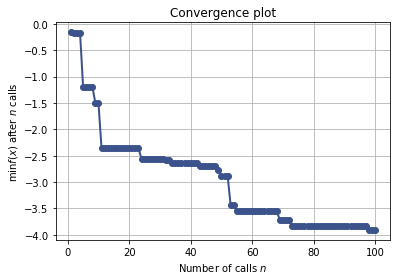

In [9]:
from skopt.plots import plot_convergence
_ = plot_convergence(gp_res);

#### Plot evaluation matrix

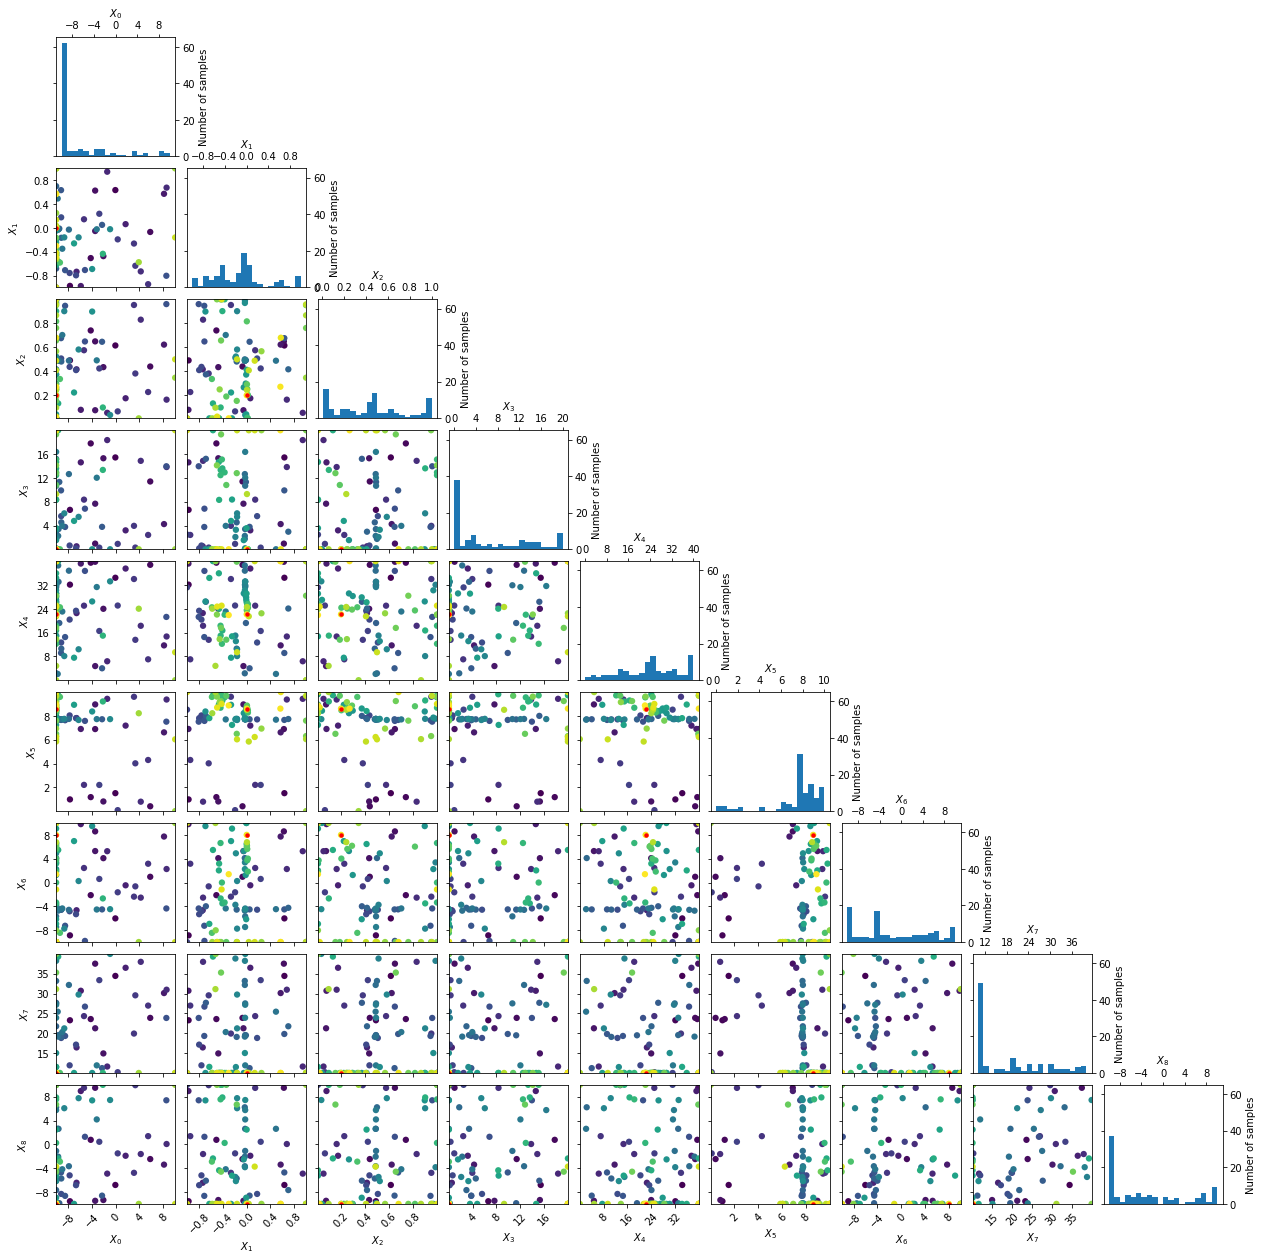

In [10]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(gp_res)

#### Plot objective matrix

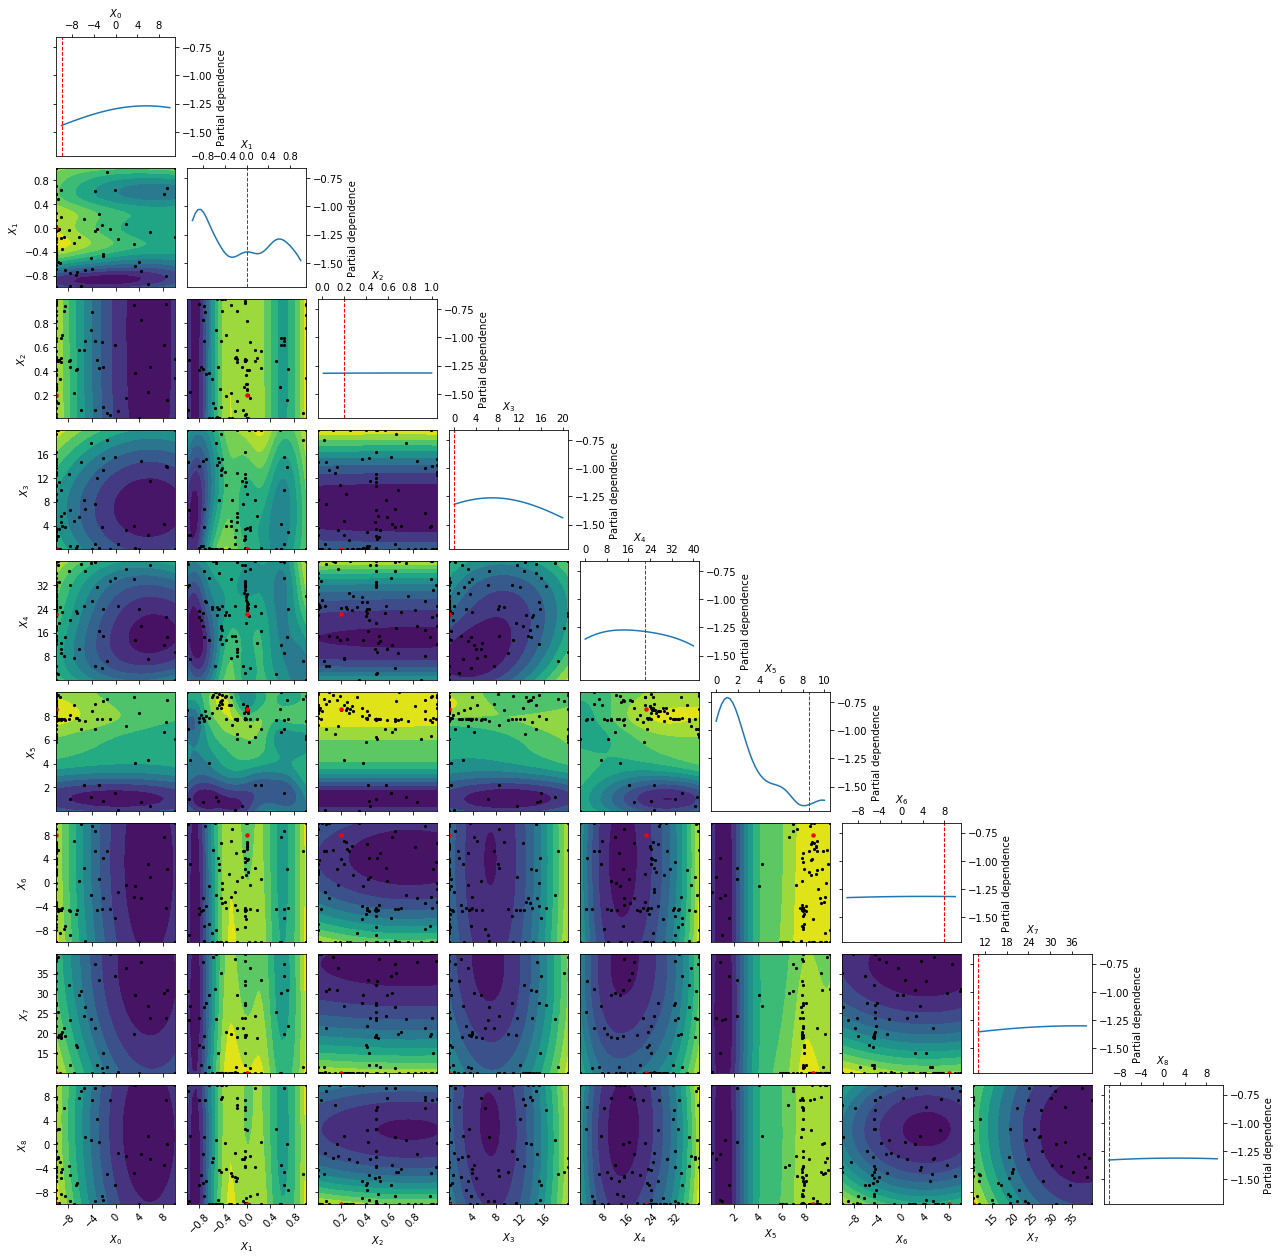

In [11]:
from skopt.plots import plot_objective
_ = plot_objective(gp_res)

### Sequential optimization using gradient boosted trees

In [ ]:
from skopt import gbrt_minimize

gbrt_res = gbrt_minimize(
    objective_function,
    parameter_space,
    acq_func = "LCB", # EI, PI, LCB, PIps, EIps
    n_calls = 15,
    n_random_starts = 5,
    random_state = random_state,
    verbose = verbose)

#### Plot convergence

In [ ]:
from skopt.plots import plot_convergence
_ = plot_convergence(gbrt_res);

#### Plot evaluation matrix

In [ ]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(gbrt_res)

#### Plot objective matrix

In [ ]:
from skopt.plots import plot_objective
_ = plot_objective(gbrt_res)

### Sequential optimisation using decision trees

In [ ]:
from skopt import forest_minimize

forest_res = forest_minimize(
    objective_function,
    parameter_space,
    n_calls = 10,
    base_estimator = "ET",
    random_state = random_state,
    verbose = verbose)

#### Plot convergence

In [ ]:
from skopt import plot_convergence
_ = plot_convergence(forest_res);

#### Plot evaluation matrix

In [ ]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(forest_res)

#### Plot objective matrix

In [ ]:
from skopt.plots import plot_objective
_ = plot_objective(forest_res)